In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import statsmodels.api   as sm

from astropy.timeseries  import LombScargle
from scipy.signal        import savgol_filter

# Derive a waveform from the phase folded data

Savitzky-Golay filter has been used for Corot and K2 data to derive a waveform, but it can't be applied to unevenly spaced data.

This notebook shows a different method that could be used : A LOESS function (Locally Weighted Scatterplot Smoothing)

Library used : statsmodels.nonparametric.smoothers_lowess 

 https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
 
 https://github.com/statsmodels/statsmodels/blob/main/statsmodels/nonparametric/smoothers_lowess.py

### Example light curve

In [2]:
def qp_burst(t, amp_mean, amp_std, period, burst_factor):
    """
    Calculate the quasi-periodic burst magnitude.

    Parameters:
    - t: Time array
    - amp_mean: Mean amplitude of the random semi-amplitude
    - amp_std: Standard deviation of the random semi-amplitude
    - period: Period of the sine wave
    - burst_factor: Burst factor quantifying burst strength

    Returns:
    - mag_qpb: Quasi-periodic burst magnitude
    """
    amp_rand = np.random.normal(amp_mean, amp_std, len(t))

    term1 = amp_rand/2 * np.sin(2 * np.pi * t / period)
    term2 = 0.5 * burst_factor * np.sin(2 * np.pi * t / period) * (1 + np.sin(2 * np.pi * t / period))

    mag_qpb = term1 + term2 + np.random.normal(0, 0.05, len(t))

    return mag_qpb

Text(0, 0.5, 'magnitude')

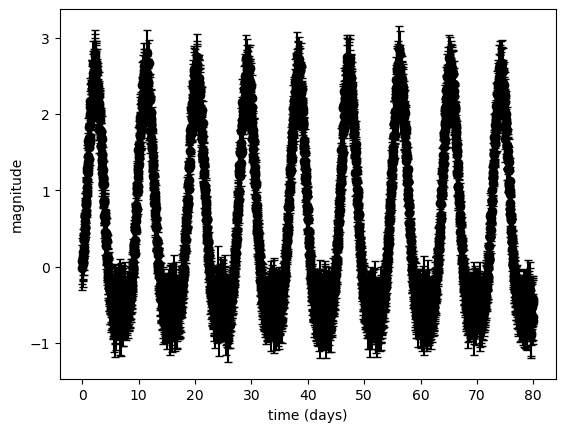

In [3]:
amp_mean     = 1
amp_std      = 0.3
burst_factor = 2
period       = 9
t            = np.arange(0, 80, 0.03)
dy           = 0.3 *np.ones(len(t))

y            =  qp_burst(t, amp_mean, amp_std, period, burst_factor)

plt.errorbar(t, y, dy, fmt='o', color='black', capsize=3)
plt.xlabel('time (days)')
plt.ylabel('magnitude')

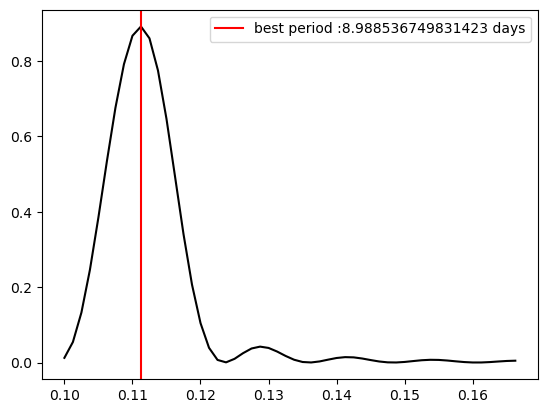

In [4]:
#Lomb-Scargle periodogram to derive the period
frequency, power = LombScargle(t, y, dy).autopower(minimum_frequency=1/10,

                                                   maximum_frequency=1/6,

                                                   samples_per_peak=10)
best_frequency = frequency[np.argmax(power)]

plt.plot(frequency, power, c = 'black')
plt.axvline(best_frequency, c = 'red', label = f'best period :{1/best_frequency} days')
plt.legend()

In [5]:
def fold(time, mag, period):
    """
    Folds the light curve in phase for a given period. 
    Returns magnitudes sorted by phase.

    Parameters:
    - mag: array-like, magnitudes (or uncertainties) of the light curve
    - time: array-like, time values of the light curve
    - period: float, period of the light curve

    Returns:
    - phase: array-like, phase values of the folded light curve
    - mag_sorted: array-like, magnitudes of the folded light curve sorted by phase
    
    """
    # Calculate the phase values
    phase = np.mod(time, period) / period
    
    # Sort the phase and magnitude arrays based on phase values
    sort = np.argsort(phase)
    phase = phase[sort]
    mag_sorted = mag[sort]
    
    return phase, mag_sorted



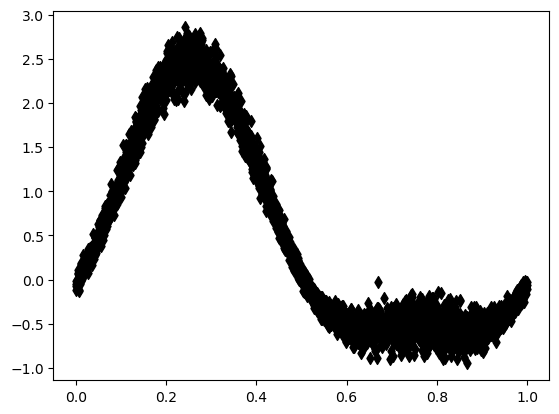

In [6]:
#Fold the light curve

t_phase, y_fold = fold(t, y, 1/best_frequency)
plt.scatter(t_phase, y_fold, c = 'black', marker = 'd')

### Compare LOESS fit with Savitzky-Golay filter

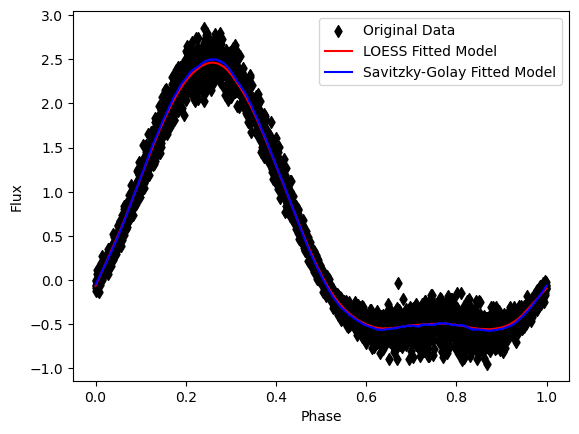

In [7]:
# Apply LOESS smoothing
lowess_result = sm.nonparametric.lowess(y_fold, t_phase, frac=0.1)
t_fit = lowess_result[:, 0]
y_fit = lowess_result[:, 1]

# Apply Savitzky-Golay filter
window_length = int(0.1 * len(t))
polyorder     = 3  
y_fit_savgol  = savgol_filter(y_fold, window_length, polyorder)
t_fit_savgol  = t_phase



plt.scatter(t_phase, y_fold, label='Original Data', c = 'black', marker = 'd')
plt.plot(t_fit, y_fit, label='LOESS Fitted Model', color='red')
plt.plot(t_fit_savgol, y_fit_savgol, label='Savitzky-Golay Fitted Model', color='blue')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.legend()
plt.show()

## Showing the effect of cadence on LOESS fit

In [8]:
def degrade(time, mag, mag_err, degrading_factor) :
    
    '''
    Degrade a given lightcurve, by removing points. The way to remove the points should be random, in order to have unevenly spaced data. 
    
    Args :
        - time, mag, mag_err : lightcurve data
        - degrading_factor : Factor indicating the amount of data to be removed from the lightcurve. Between 0 and 1 : 0 == 0% of the lightcurve will be removed ; 1 == 100% of the lightcurve will be removed
        
    Returns :
        - time_degraded, mag_degraded, mag_err_degraded
    '''
    
     # Check if degrading factor is within valid range
    if not (0 <= degrading_factor <= 1):
        raise ValueError("Degrading factor must be between 0 and 1.")

    # Calculate the number of points to keep
    num_points_to_keep = int(len(time) * (1 - degrading_factor))

    # Randomly select points to keep
    indices_to_keep = np.random.choice(len(time), num_points_to_keep, replace=False)

    # Sort the indices to maintain the time order
    indices_to_keep.sort()

    # Create degraded lightcurve
    time_degraded    = time[indices_to_keep]
    mag_degraded     = mag[indices_to_keep]
    mag_err_degraded = mag_err[indices_to_keep]

    return time_degraded, mag_degraded, mag_err_degraded

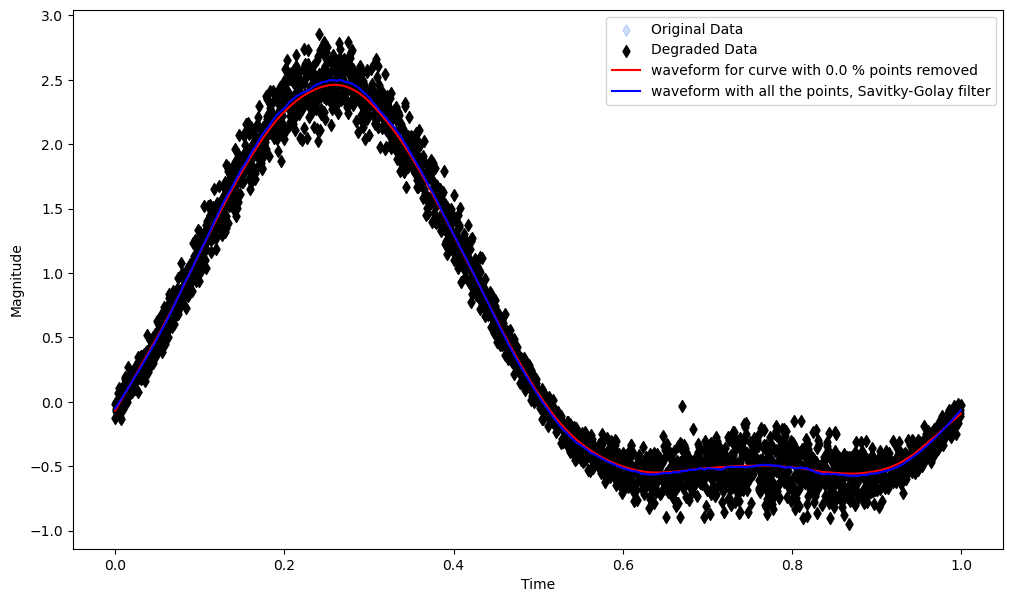

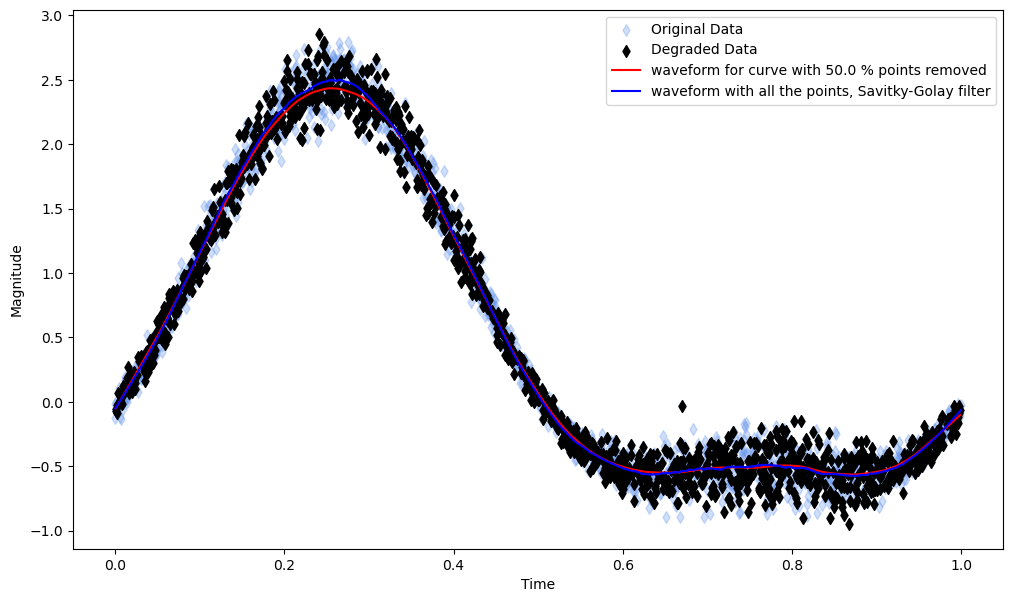

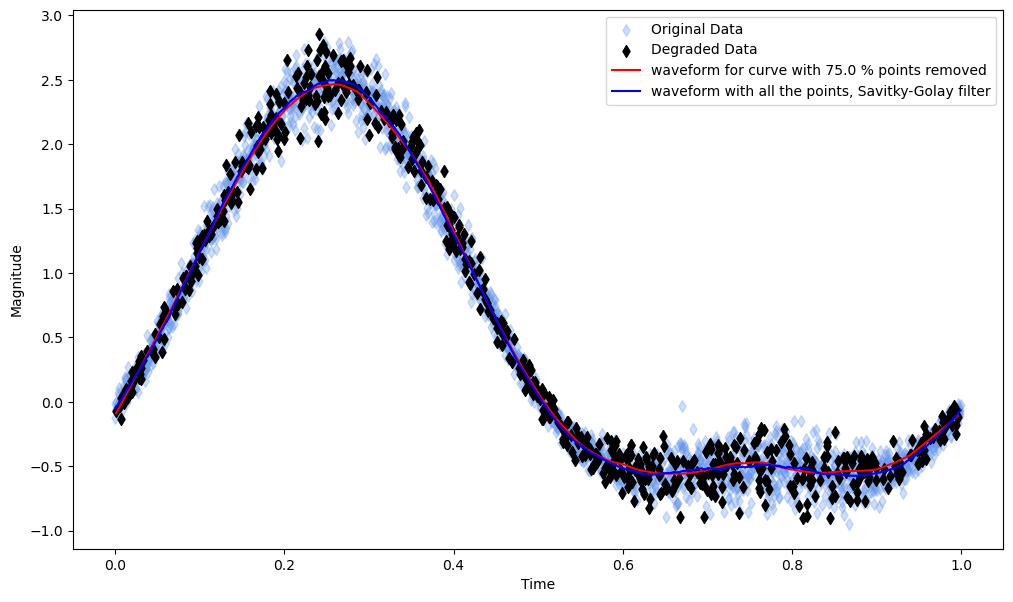

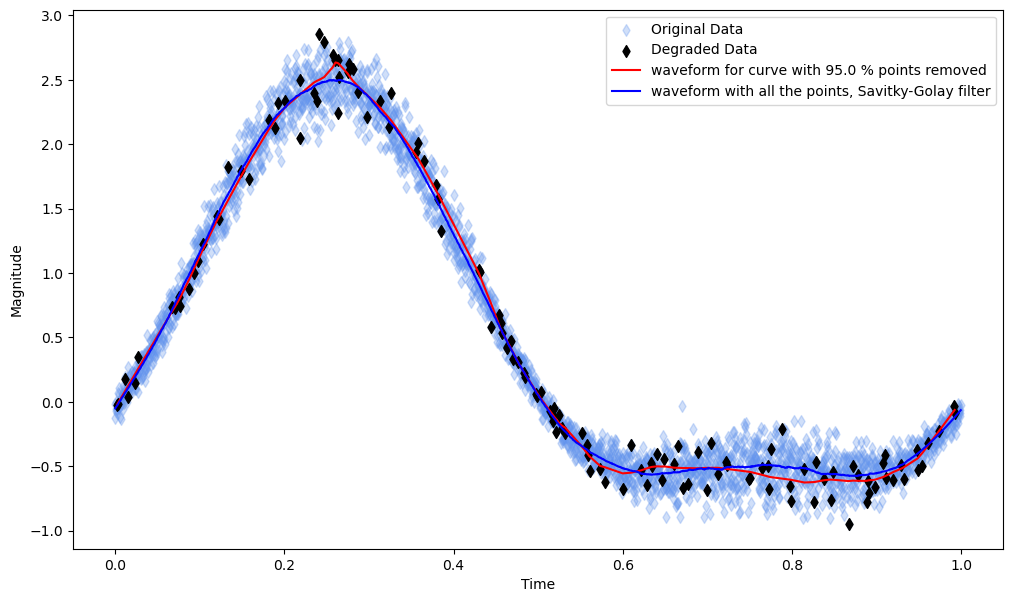

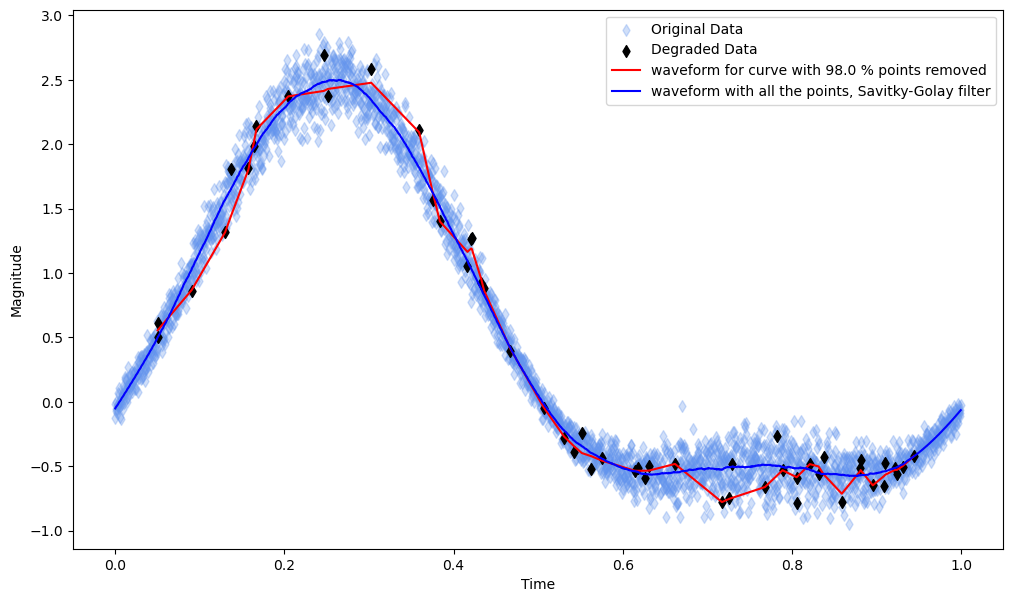

In [9]:
# Derive 6 other lightcurves from it, by gradually removing points
degrade_factors = [0.0, 0.5, 0.75, 0.95, 0.98]
degraded_lcs    = []

for factor in degrade_factors:
    time_deg, mag_deg, mag_err_deg = degrade(t, y, dy, factor)
    degraded_lcs.append((time_deg, mag_deg, mag_err_deg))


for idx, (time_deg, mag_deg, mag_err_deg) in enumerate(degraded_lcs):
    
    #Phase fold the degraded curve
    t_phase_deg, y_fold_deg = fold(np.array(time_deg), np.array(mag_deg), 1/best_frequency)
    
    # Apply LOESS smoothing to phase folded curve
    lowess_result = sm.nonparametric.lowess(y_fold_deg, t_phase_deg, frac=0.1)

    t_fit_deg = lowess_result[:, 0]
    y_fit_deg = lowess_result[:, 1]

    
    # Plot the LOESS model
    plt.figure(figsize = (12, 7))
    plt.scatter(t_phase, y_fold, label='Original Data', c='cornflowerblue', marker='d', alpha = .3)
    plt.scatter(t_phase_deg, y_fold_deg, label='Degraded Data', c='black', marker='d')
    plt.plot(t_fit_deg, y_fit_deg,\
             label=f'waveform for curve with {100 * degrade_factors[idx]} % points removed',\
             c = 'red')
    plt.plot(t_fit_savgol, y_fit_savgol,\
             label=f'waveform with all the points, Savitky-Golay filter', c = 'blue')

    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.show()